In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib as mpl
# import requests
# import folium
# import numpy as np
from utils import *
# import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
%matplotlib inline



In [4]:
def Display_Plot(df:pd.DataFrame, plot_type, axis:pd.DataFrame.axes, title, color):
    if plot_type == "bar":
        # axis.bar(x= df["Year"], height = df["Total Reviews"], color=color, width=2)
        axis.bar(x= df["Year"], height = df["Total Reviews"], color=color)
        for index, col in enumerate(df["Total Reviews"]):
            txt_len = len(str(col))
            axis.annotate(str(col), xy=(index,col), xytext=(-txt_len,txt_len*1.2), textcoords='offset points', rotation=-45)
    elif plot_type == "pie":
        axis.pie(x = df["Total Reviews"], labels = df["Year"], color = color)
    else:
        axis.plot(df["Year"], df["Total Reviews"])
    axis.set_title(title[::-1])
    axis.set_ymargin(0.15)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\2302187205.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{cat}.csv")
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocat

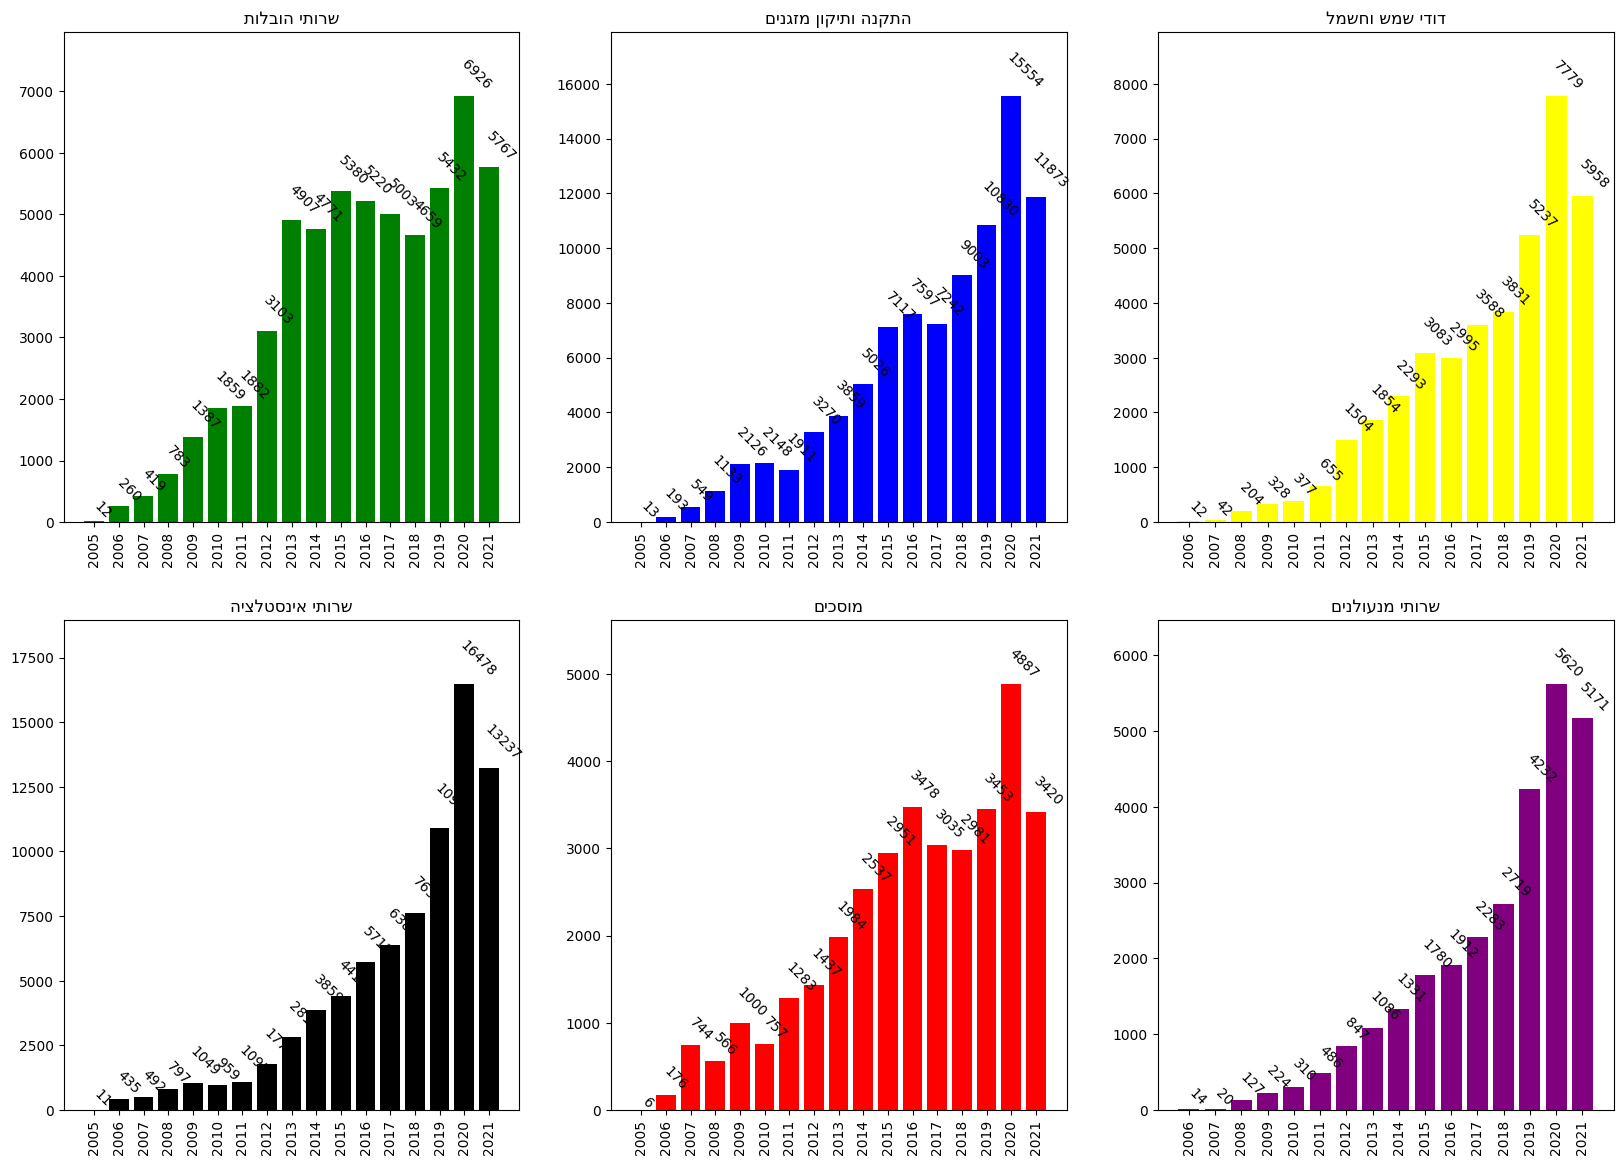

In [89]:
fig, axes = plt.subplots(2,3, figsize=(20,14))
colors = [
    ['green', 'blue','yellow'],
    ['black', 'red', 'purple']
]
# plt.xticks(rotation=90)
categories_csv = Get_All_CSV_Names()
row = 0
index = 0
for cat in categories_csv:
    df = pd.read_csv(f"data/{cat}.csv")
    
    df_dict = pd.DataFrame.from_dict(df["Year"].value_counts().to_dict(), orient="index", columns=["Total Reviews"])
    df_dict.reset_index(inplace=True)
    df_dict.rename(columns={'index':'Year'}, inplace = True)
    df_dict.sort_values(by="Year", inplace=True)
    df_dict['Year'] = df_dict["Year"].astype(str)
    Display_Plot(df_dict, "bar", axes[row, index], cat, colors[row][index])
    
    if index == 2:
        row = 1
        index = 0
    else:
        index+=1
    
    Save_CSV(f"/ML/summery_{cat}.csv", df_dict)

In [34]:
def Display_Graph_Seaborn(df:pd.DataFrame, x_axis, y_axis, hue_title, plot_type, axis:pd.DataFrame.axes, main_title, hue_order):
    if plot_type == 'line':
        sns.lineplot(ax=axis, x=x_axis, y=y_axis, hue=hue_title, hue_order=hue_order, data=df, marker="o", markersize=5)
        axis.set_title(main_title)
        axis.tick_params(labelrotation=90)

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_18932\831689548.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{csv}.csv")


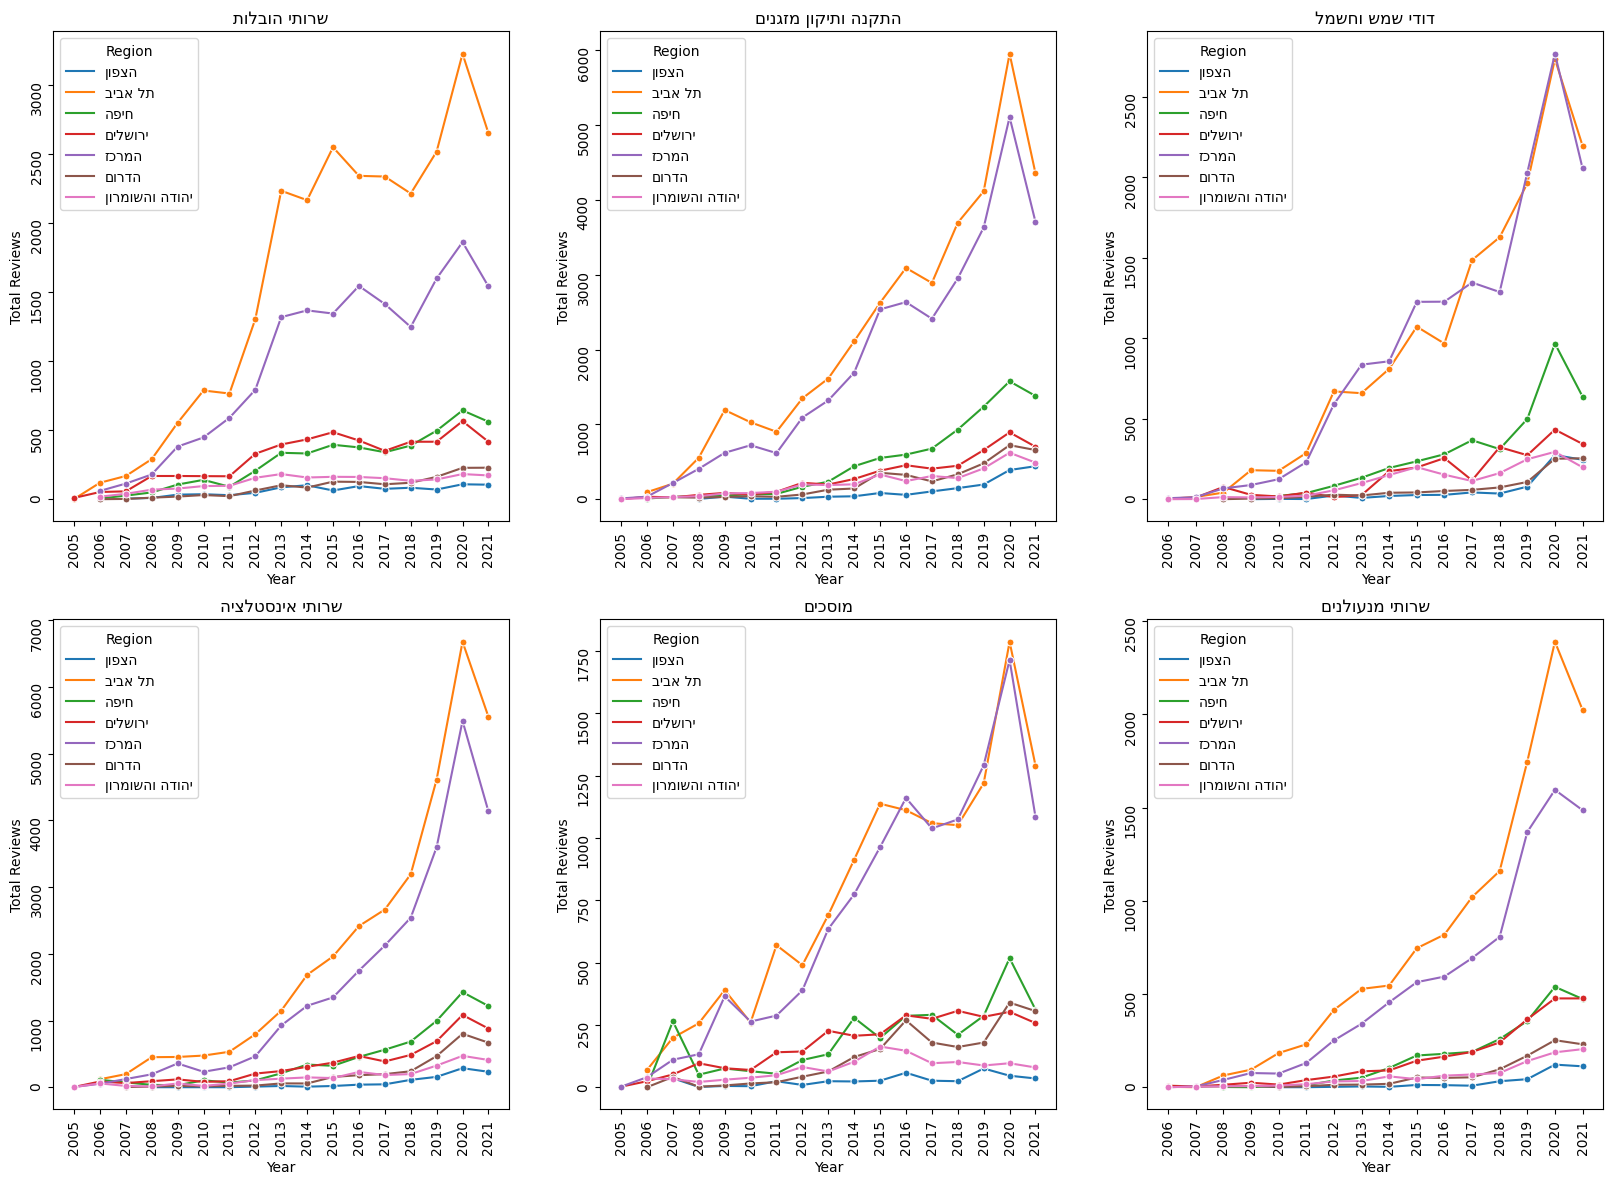

In [36]:
filenames = Get_All_CSV_Names()

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
#fig.suptitle('גידול ענפי שירות לפי איזורים'[::-1])

regions = ['ןופצה', 'ביבא לת', 'הפיח', 'םילשורי', 'זכרמה', 'םורדה', 'ןורמושהו הדוהי']

row = 0
index = 0

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.drop(df[df.Region == 'חסוי'].index, inplace=True)
    
    df["Year"] = df["Year"].astype(str)
    df["Region"] = df["Region"].apply(lambda x: x[::-1])
    
    grouped = df.groupby([df['Year'], 'Region'])

    reviews_per_year_and_region = grouped['Region'].count().reset_index(name='Total Reviews')
    
    Display_Graph_Seaborn(reviews_per_year_and_region, "Year", "Total Reviews", "Region", 'line', axes[row,index], csv[::-1], regions)

    if index == 2:
        row = 1
        index = 0
    else:
        index+=1




C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42052\1841804103.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{csv}.csv")
c:\Users\Daniel Ventura\Documents\GitHub\midrag\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['הביס', 'הביסה', 'הדימ', 'הללגבש', 'העשב', 'וב', 'ובש', 'וזיאב', 'וזיאל', 'וזיאמ', 'םוקמ', 'םוקמב', 'םוקמל', 'תילכת'] not in stop_words.
  warnings.warn(


לא היה 5638
לא הייתי 2370
לא היו 1635
לא הייתה 1369
לא יודע 1250
לא הצליח 1110
לא הגיע 1049
לא כל 1007
לא עשה 832
לא מרוצה 787
לא לקח 742
לא יודעת 739
לא ממש 735
לא יכול 732
לא נשבר 730
לא פתר 651
לא נפתרה 573
לא טוב 568
לא גבה 524
לא זול 501
לא עבד 463
לא מקצועי 458
לא עשיתי 437
לא עובד 430
לא בטוח 425
לא נעים 418
לא רצה 404
לא משהו 392
לא צריך 382
לא טובה 381
לא היתה 349
לא נעימה 343
לא הכי 339
לא אמר 335
לא ניסה 320
לא איחר 320
לא יכל 314
לא חזר 314
לא ידע 309
לא נתקלתי 304
לא עשו 296
לא אהבתי 289
לא תיקן 277
לא בסדר 277
לא עזר 268
לא נראה 266
לא יכולה 259
לא מספיק 259
לא שברו 254
לא מצא 250
לא הגיעו 245
לא יקר 244
לא כ 241
לא ידעו 234
לא עמד 230
לא ראיתי 229
לא מבינה 225
לא ענה 223
לא מעט 222
לא הרגשתי 221
לא בדק 221
לא נורא 218
לא קירר 218
לא הסכים 217
לא הצליחו 216
לא נתן 215
לא בדקתי 214
לא סיים 210
לא קיבלתי 208
לא מקצועית 200
לא היינו 195
לא השאיר 193
לא בא 189
לא רציתי 177
לא ניתן 177
לא ביקש 174
לא ממליץ 173
לא רק 173
לא יותר 168
לא יפה 166
לא חייב 165
לא ידעתי 162
לא תקין 1

c:\Users\Daniel Ventura\Documents\GitHub\midrag\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['הביס', 'הביסה', 'הדימ', 'הללגבש', 'העשב', 'וב', 'ובש', 'וזיאב', 'וזיאל', 'וזיאמ', 'םוקמ', 'םוקמב', 'םוקמל', 'תילכת'] not in stop_words.
  warnings.warn(


לא היה 4047
לא הייתי 1382
לא לקח 1345
לא היו 1304
לא הייתה 1095
לא הצליח 998
לא גבה 913
לא יודע 754
לא נשבר 695
לא ניסה 647
לא נתקלתי 610
לא הגיע 577
לא עשה 494
לא יודעת 477
לא יכול 458
לא צריך 456
לא כל 452
לא עשיתי 448
לא רצה 446
לא עבד 427
לא ראיתי 426
לא הצליחו 420
לא נפתרה 413
לא יקר 406
לא יכל 346
לא פתר 324
לא הסכים 313
לא היתה 307
לא ממש 283
לא שברו 282
לא עזב 279
לא ביקש 279
לא זול 275
לא רק 260
לא קירר 242
לא מרוצה 240
לא עשו 234
לא מצא 229
לא הכי 220
לא בדקתי 218
לא סתם 214
לא טוב 207
לא עובד 207
לא בטוח 207
לא פגשתי 207
לא פשוטה 191
לא מובן 190
לא התלוננו 187
לא יכולתי 184
לא איחר 184
לא פעם 182
לא השאיר 180
לא משהו 178
לא ידעתי 175
לא הלך 175
לא תיקן 166
לא ידע 166
לא ויתר 164
לא טובה 160
לא נתן 160
לא היינו 159
לא בסדר 154
לא אמר 154
לא מבין 153
לא קיבלתי 152
לא חייב 149
לא נפגע 147
לא נעים 146
לא חזר 143
לא לקחו 142
לא עזר 140
לא דרש 139
לא לתקן 138
לא חימם 136
לא בא 132
לא מעט 128
לא באשמתו 124
לא כדאי 124
לא ציפיתי 124
לא ניתן 124
לא חזרה 123
לא וויתר 119
לא נגרם 113
ל

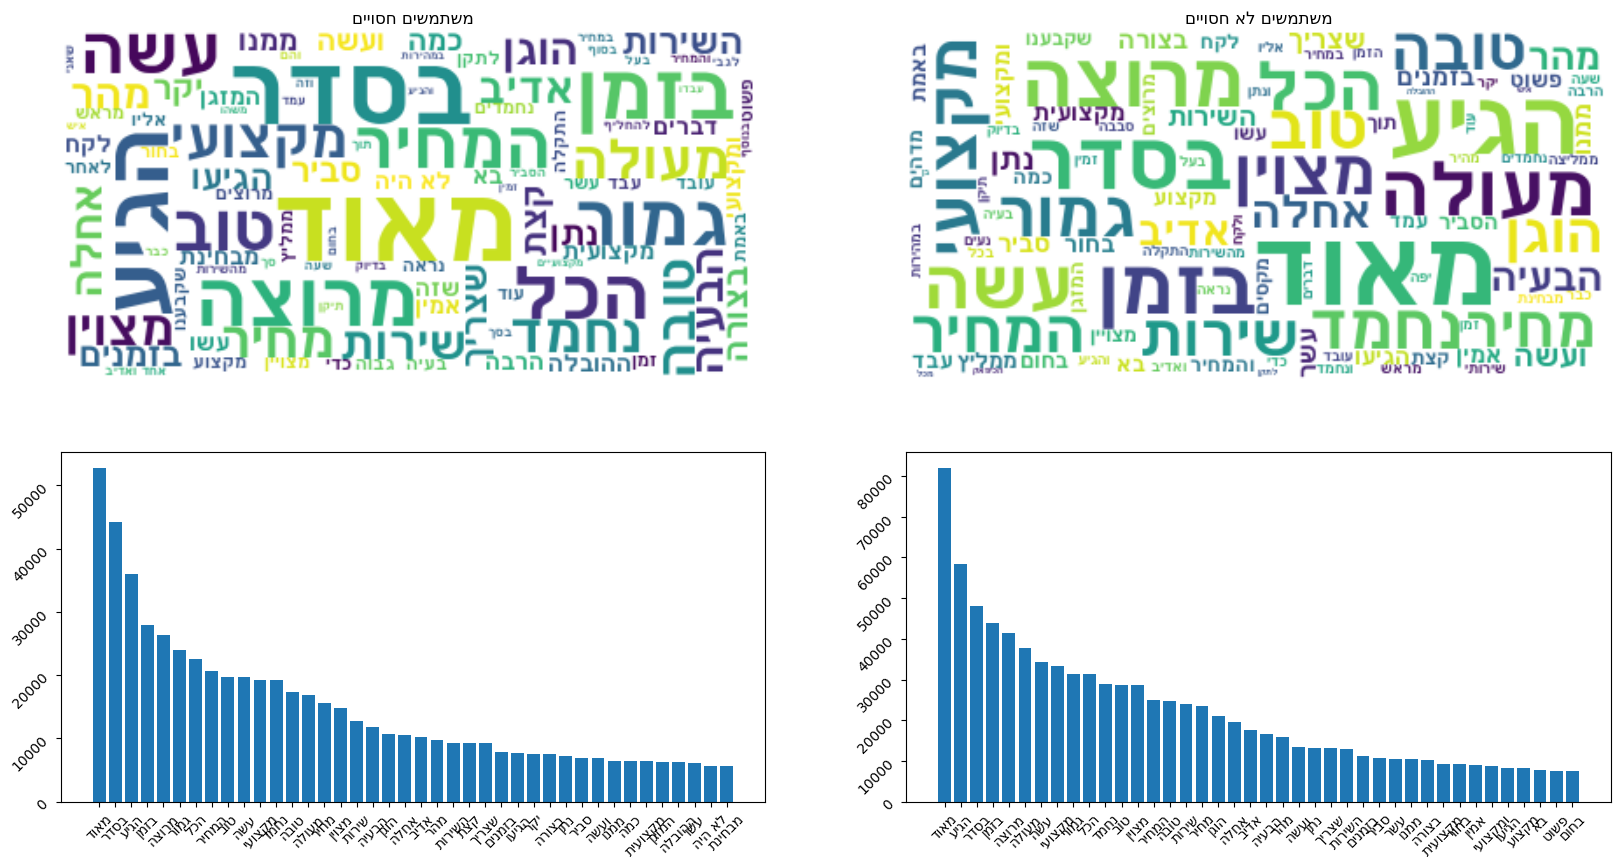

In [86]:
# Check difference between 'חסוי' and visible reviews
#font_path=r'C:\Users\Omer\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'
font_path=r'C:\Users\Daniel Ventura\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'
stop_words = ['לדעתי', 'העבודה', 'עבודה', 'שהיה', 'שזהו', 'שהם', 'והכל', 'יום', 'הכי', 'והיה', 'והוא', 'שהוא', 'לעשות','אמר', 'ולא', 'ואני', 'דבר','הייתי', 'הייתה', 'צריך', 'וגם', 'אדם', 'היו', 'ממש','שלי','לי','הם','אני', 'את', 'אתה', 'אנחנו', 'אתן', 'אתם', 'הם', 'הן', 'היא', 'הוא', 'שלי', 'שלו', 'שלך', 'שלה', 'שלנו', 'שלכם', 'שלכן', 'שלהם', 'שלהן', 'לי', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'אותה', 'אותו', 'זה', 'זאת', 'אלה', 'אלו', 'תחת', 'מתחת', 'מעל', 'בין', 'עם', 'עד', 'נגר', 'על', 'אל', 'מול', 'של', 'אצל', 'כמו', 'אחר', 'אותו', 'בלי', 'לפני', 'אחרי', 'מאחורי', 'עלי', 'עליו', 'עליה', 'עליך', 'עלינו', 'עליכם', 'עליכן', '10','עליהם', 'עליהן', 'כל', 'כולם', 'כולן', 'כך', 'ככה', 'כזה', 'זה', 'זות', 'אותי', 'אותה', 'אותם', 'אותך', 'אותו', 'אותן', 'אותנו', 'ואת', 'את', 'אתכם', 'אתכן', 'איתי', 'איתו', 'איתך', 'איתה', 'איתם', 'איתן', 'איתנו', 'איתכם', 'איתכן', 'יהיה', 'תהיה', 'היתי', 'היתה', 'היה', 'להיות', 'עצמי', 'עצמו', 'עצמה', 'עצמם', 'עצמן', 'עצמנו', 'עצמהם', 'עצמהן', 'מי', 'מה', 'איפה', 'היכן', 'במקום שבו', 'אם', 'לאן', 'למקום שבו', 'מקום בו', 'איזה', 'מהיכן', 'איך', 'כיצד', 'באיזו מידה', 'מתי', 'בשעה ש', 'כאשר', 'כש', 'למרות', 'לפני', 'אחרי', 'מאיזו סיבה', 'הסיבה שבגללה', 'למה', 'מדוע', 'לאיזו תכלית', 'כי', 'יש', 'אין', 'אך', 'מנין', 'מאין', 'מאיפה', 'יכל', 'יכלה', 'יכלו', 'יכול', 'יכולה', 'יכולים', 'יכולות', 'יוכלו', 'יוכל', 'מסוגל', 'לא', 'רק', 'אולי', 'אין', 'לאו', 'אי', 'כלל', 'נגד', 'אם', 'עם', 'אל', 'אלה', 'אלו', 'אף', 'על', 'מעל', 'מתחת', 'מצד', 'בשביל', 'לבין', 'באמצע', 'בתוך', 'דרך', 'מבעד', 'באמצעות', 'למעלה', 'למטה', 'מחוץ', 'מן', 'לעבר', 'מכאן', 'כאן', 'הנה', 'הרי', 'פה', 'שם', 'אך', 'ברם', 'שוב', 'אבל', 'מבלי', 'בלי', 'מלבד', 'רק', 'בגלל', 'מכיוון', 'עד', 'אשר', 'ואילו', 'למרות', 'אס', 'כמו', 'כפי', 'אז', 'אחרי', 'כן', 'לכן', 'לפיכך', 'מאד', 'עז', 'מעט', 'מעטים', 'במידה', 'שוב', 'יותר', 'מדי', 'גם', 'כן', 'נו', 'אחר', 'אחרת', 'אחרים', 'אחרות', 'אשר', 'או']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

txt_hidden = ""
txt_not_hidden = ""

df_main = pd.DataFrame()
filenames = Get_All_CSV_Names()

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.Review = df.Review.str.replace(" שלא ", " לא ")
    df.Review = df.Review.str.replace(" ולא ", " לא ")
    df.Review = df.Review.str.replace(" לא ", " 700")

    txt_hidden += df.loc[df["Is Hidden"] == 1].Review.str.cat(sep=' ')
    txt_not_hidden += df.loc[df["Is Hidden"] == 0].Review.str.cat(sep=' ')

txt_hidden = txt_hidden[::-1]
txt_not_hidden = txt_not_hidden[::-1]

for index, word in enumerate(stop_words):
    stop_words[index] = word[::-1]

txt_list = [txt_hidden, txt_not_hidden]
title = ["משתמשים חסויים", "משתמשים לא חסויים"]
index = 0

for txt in txt_list:
    vectorizer=CountVectorizer(stop_words=stop_words)
    freq_vec=vectorizer.fit_transform([txt]).toarray() 
    freqDist=dict(zip(vectorizer.get_feature_names_out(),freq_vec[0])) 
    freqDist=dict(sorted(freqDist.items(), key=lambda item: item[1],reverse=True))

    freqDist = {key.replace('007', ' אל'): value for key, value in freqDist.items()}

    wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white", font_path=font_path).generate_from_frequencies(freqDist)

    axes[0,index].imshow(wordcloud, interpolation="bilinear")
    axes[0,index].axis("off")
    axes[0,index].set_title(title[index][::-1])

    topK=40
    axes[1,index].bar(list(freqDist.keys())[:topK], list(freqDist.values())[:topK])
    axes[1,index].tick_params(labelrotation=45)

    index += 1

    for key in freqDist.keys():
        if " אל" in key:
            print(key[::-1], freqDist[key])

    #print(list(freqDist.keys()), list(freqDist.values()))

In [ ]:
# Image - Wordcloud

# def transform_format(val):
#     if val != 0:
#         return 255
#     else:
#         return val


# image_file=Image.open("./images/alice.png")
# image_file=image_file.convert('1')
# alice_mask = np.array(image_file)

# transformed_alice_mask = np.ndarray((alice_mask.shape[0],alice_mask.shape[1]), np.int32)

# for i in range(len(alice_mask)):
#     transformed_alice_mask[i] = list(map(transform_format, alice_mask[i]))

# wc = WordCloud(background_color="white", max_words=100, mask=transformed_alice_mask,contour_width=3, contour_color='gray')

# wc=wc.generate_from_frequencies(freqDist)
# plt.figure(figsize=[20,10])
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [ ]:
# Create a Map that takes array of [locations, total_reviews] as an input, gets the Geo-Location of each location (using OpenStreeMap API) and Pin-Points the Top-5 Locations with the most reviews

# import requests

# map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

# df = pd.read_csv("data\\reviews.csv")

# df['Location'] = df['Location'].astype(str)
# df['Location'] = df['Location'][~df['Location'].str.contains(r'\d')]
# places = df['Location'].value_counts().to_dict()

# places_dict = []
# for location, total_reviews in places.items():
#     places_dict.append({'name': location, 'total_reviews': total_reviews})

# places_dict= sorted(places_dict, key=lambda x: x['total_reviews'], reverse=True)

# for place in places_dict[:5]:
#     popup = folium.Popup(f'<center><font size="2"><b>{place["name"]}</b></font><br><u>ביקורות</u>: {place["total_reviews"]}', max_width=300)

#     url = f'https://nominatim.openstreetmap.org/search?q={place["name"]}+Israel&format=json'
#     response = requests.get(url).json()
#     if response:
#         lat = response[0]['lat']
#         lon = response[0]['lon']

#     folium.Marker(location=[lat, lon], popup=popup).add_to(map)

# map

In [12]:
# Checking Population of each Town in Israel (after getting the Geo-Location of them)
# df_towns = pd.read_csv("data\\israel_towns.csv")

# map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

# for index, row in df_towns.iterrows():
#     if( pd.notnull(row['Geo_lat']) & pd.notnull(row['Geo_lon']) ):
#         popup = folium.Popup(f'<center><font size="2"><b>{row["Name"]}</b></font><br><u>תושבים:</u>: {row["Population"]}', max_width=300)

#         folium.Marker(location=[row["Geo_lat"], row["Geo_lon"]], popup=popup).add_to(map)

# map

In [10]:
# Create a dataframe with city names and their corresponding values
# data = {'city': ['ירושלים', 'Tel Aviv', 'Haifa', 'Petah Tikva', 'Ashdod'],
#         'value': [100, 75, 50, 25, 0]}
# df = pd.DataFrame(data)
 
# # Create a map object
# m = folium.Map(location=[31.0461, 34.8516], zoom_start=8)
 
# # Use the geo.json file to create the choropleth map
# folium.Choropleth(
#     geo_data='data/map/israel-geojson.json',
#     data=df,
#     columns=['city', 'value'],
#     key_on='feature.properties.HEB_NAME',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Value'
# ).add_to(m)
 
# # Add a layer control to toggle the choropleth layer on/off
# folium.LayerControl().add_to(m)
 
# Display the map
# m